In [0]:

# !pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 
# !pip3 install torchvision

In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision
from torchvision import transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import cv2 

In [43]:
from google.colab import drive
drive.mount('/content/gdrive');

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# Import train, validation and test images from the folders and store in a list

import os

# To load images

def load_img(folder):
    c = 0;
    images = [];
    for filename in os.listdir(folder): # List all the filenames in the folder
        c = c + 1;
        print(c);
        img = cv2.imread(os.path.join(folder, filename)); # Join the link of the folder and filename
        img = cv2.resize(img, (128, 128), interpolation = cv2.INTER_AREA);
        images.append(img);
    return images

# To load labeled gray-scaled images

def load_label_img(folder):
    images = [];
    c = 0;
    for filename in os.listdir(folder): # List all the filenames in the folder
        c = c + 1;
        print(c);
        img = cv2.imread(os.path.join(folder, filename)); # Join the link of the folder and filename
        img = cv2.resize(img, (128, 128), interpolation = cv2.INTER_AREA);
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY);
        images.append(img);
    return images


In [0]:
# Convert the output labels to pixel-wise classes

def c2g(cn):
    cn = np.reshape(cn, (1, 1, 3));
    cn = cv2.cvtColor(cn, cv2.COLOR_BGR2GRAY);
    return cn;

colors = [];
colors.append(c2g(np.array([64, 128, 64], dtype = 'uint8')));
colors.append(c2g(np.array([128, 0, 192], dtype = 'uint8')));
colors.append(c2g(np.array([192, 128, 0], dtype = 'uint8')));
colors.append(c2g(np.array([64, 128, 0], dtype = 'uint8')));
colors.append(c2g(np.array([0, 0, 128], dtype = 'uint8')));
colors.append(c2g(np.array([128, 0, 64], dtype = 'uint8')));
colors.append(c2g(np.array([192, 0, 64], dtype = 'uint8')));
colors.append(c2g(np.array([64, 128, 192], dtype = 'uint8')));
colors.append(c2g(np.array([128, 192, 192], dtype = 'uint8')));
colors.append(c2g(np.array([128, 64, 64], dtype = 'uint8')));
colors.append(c2g(np.array([192, 0, 128], dtype = 'uint8')));
colors.append(c2g(np.array([64, 0, 192], dtype = 'uint8')));
colors.append(c2g(np.array([64, 128, 128], dtype = 'uint8')));
colors.append(c2g(np.array([192, 0, 192], dtype = 'uint8')));
colors.append(c2g(np.array([64, 64, 128], dtype = 'uint8')));
colors.append(c2g(np.array([128, 192, 64], dtype = 'uint8')));
colors.append(c2g(np.array([0, 64, 64], dtype = 'uint8')));
colors.append(c2g(np.array([128, 64, 128], dtype = 'uint8')));
colors.append(c2g(np.array([192, 128, 128], dtype = 'uint8')));
colors.append(c2g(np.array([192, 0, 0], dtype = 'uint8')));
colors.append(c2g(np.array([128, 128, 192], dtype = 'uint8')));
colors.append(c2g(np.array([128, 128, 128], dtype = 'uint8')));
colors.append(c2g(np.array([192, 128, 64], dtype = 'uint8')));
colors.append(c2g(np.array([64, 0, 0], dtype = 'uint8')));
colors.append(c2g(np.array([64, 64, 0], dtype = 'uint8')));
colors.append(c2g(np.array([128, 64, 192], dtype = 'uint8')));
colors.append(c2g(np.array([0, 128, 128], dtype = 'uint8')));
colors.append(c2g(np.array([192, 128, 192], dtype = 'uint8')));
colors.append(c2g(np.array([64, 0, 64], dtype = 'uint8')));
colors.append(c2g(np.array([0, 192, 192], dtype = 'uint8')));
colors.append(c2g(np.array([0, 0, 0], dtype = 'uint8')));
colors.append(c2g(np.array([0, 192, 64], dtype = 'uint8')));

# c0 = np.reshape(np.array([64, 128, 0], dtype = 'uint8'), (1, 1, 3)); # opencv supports uint8 and not int32/int64
# c0 = cv2.cvtColor(c0, cv2.COLOR_BGR2GRAY)
# print(c0)

def class_pixel(label_img):
    class_pix = np.ones([128, 128, 1], dtype = int);
    for index, c in enumerate(colors):
        class_pix[label_img == c] = index; # Vectorized masking is much much faster
    return class_pix



In [0]:
# Convert all segmented images into labeled images

def label_img_list(img_list):
    images = [];
    for image in img_list:
        images.append(class_pixel(image));
    return images;


In [47]:
# Define the transformations that have to be applied on the images

transform_img = transforms.Compose([ 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],   # input[channel] = (input[channel] - mean[channel]) / std[channel]
                        std=[0.5, 0.5, 0.5])]);

transform_img_label = transforms.Compose([
    transforms.ToTensor()
]);

from torch.utils.data import Dataset, DataLoader

# We have to create custom classes in order to use the DataLoader. These classes inherit the Dataset class

class trainset(data.Dataset):
    def __init__(self, transform = None, root_train = None, root_train_label = None, transform_label = None):
        self.train_img = load_img(root_train);
        self.transform = transform;
        self.transform_label = transform_label;
        self.train_label_img = label_img_list(load_label_img(root_train_label));
        
    def __len__(self):
        return len(self.train_img);
    
    def __getitem__(self, index):
        img = self.transform(self.train_img[index]);
        label = self.transform_label(self.train_label_img[index]);
        return img, label;

class valset(data.Dataset):
    def __init__(self, transform = None, root_val = None, root_val_label = None, transform_label = None):
        self.val_img = load_img(root_val);
        self.transform = transform;
        self.transform_label = transform_label;
        self.val_label_img = label_img_list(load_label_img(root_val_label));
        
    def __len__(self):
        return len(self.val_img);
    
    def __getitem__(self, index):
        img = self.transform(self.val_img[index]);
        label = self.transform_label(self.val_label_img[index]);
        return img, label;

    
class testset(data.Dataset):
    def __init__(self, transform = None, root_test = None, root_test_label = None, transform_label = None):
        self.test_img = load_img(root_test);
        self.transform = transform;
        self.transform_label = transform_label;
        self.test_label_img = label_img_list(load_label_img(root_test_label));
        
    def __len__(self):
        return len(self.test_img);
    
    def __getitem__(self, index):
        img = self.transform(self.test_img[index]);
        label = self.transform_label(self.test_label_img[index]);
        return img, label;


traindataset = trainset(transform_img, '/content/gdrive/My Drive/Camvid dataset/train/', '/content/gdrive/My Drive/Camvid dataset/train_labels/', transform_img_label);
# valdataset = valset(transform_img, '/content/gdrive/My Drive/Camvid dataset/val/', '/content/gdrive/My Drive/Camvid dataset/val_labels/', transform_img_label);
testdataset = testset(transform_img, '/content/gdrive/My Drive/Camvid dataset/test/', '/content/gdrive/My Drive/Camvid dataset/test_labels/', transform_img_label);

# We have to instantiate these classes and feed this to the dataloader

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [0]:
train_loader = data.DataLoader(traindataset, batch_size = 1, shuffle=True,  num_workers=4);
# val_loader = data.DataLoader(valdataset, batch_size = 32, shuffle=True,  num_workers=4);
test_loader = data.DataLoader(testdataset, batch_size = 1, shuffle=True,  num_workers=4);

In [0]:
import torch
from torch import nn
from torch.nn import functional as F


class Fast_SCNN(torch.nn.Module):
    def __init__(self, input_channel, num_classes):
        super().__init__()

        self.learning_to_downsample = LearningToDownsample(input_channel)
        self.global_feature_extractor = GlobalFeatureExtractor()
        self.feature_fusion = FeatureFusionModule()
        self.classifier = Classifier(num_classes)

    def forward(self, x):
        # print('before everything size = ', x.size())
        shared = self.learning_to_downsample(x)
        #print('After learning_to ds size of o/p = ',shared.size())
        x = self.global_feature_extractor(shared)
        #print('After global_feat extr size of o/p = ',x.size())
        x = self.feature_fusion(shared, x)
        #print('After feat fusion size of o/p = ',x.size())
        x = self.classifier(x)
        #print('After classifier i.e. finally size of o/p = ',x.size())
        torch.nn.Dropout(0.3)
        x = F.interpolate(input= x, scale_factor=8, mode='bilinear', align_corners=True)
        #print('Finally???????',x.size())
        return x


class LearningToDownsample(torch.nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv1 = ConvBlock(in_channels=in_channels, out_channels=32, stride=2)
        self.sconv1 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1, dilation=1, groups=32, bias=False),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 48, kernel_size=1, stride=1, padding=0, dilation=1, groups=1, bias=False),
            nn.BatchNorm2d(48),
            nn.ReLU(inplace=True))
        self.sconv2 = nn.Sequential(
            nn.Conv2d(48, 48, kernel_size=3, stride=2, padding=1, dilation=1, groups=48, bias=False),
            nn.BatchNorm2d(48),
            nn.Conv2d(48, 64, kernel_size=1, stride=1, padding=0, dilation=1, groups=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))

    def forward(self, x):
        x = self.conv1(x)
        x = self.sconv1(x)
        x = self.sconv2(x)
        return x


class GlobalFeatureExtractor(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.first_block = nn.Sequential(InvertedResidual(64, 64, 2, 6),
                                         InvertedResidual(64, 64, 1, 6),
                                         InvertedResidual(64, 64, 1, 6))
        self.second_block = nn.Sequential(InvertedResidual(64, 96, 2, 6),
                                          InvertedResidual(96, 96, 1, 6),
                                          InvertedResidual(96, 96, 1, 6))
        self.third_block = nn.Sequential(InvertedResidual(96, 128, 1, 6),
                                         InvertedResidual(128, 128, 1, 6),
                                         InvertedResidual(128, 128, 1, 6))
        self.ppm = PSPModule(128, 128)

    def forward(self, x):
        x = self.first_block(x)
        x = self.second_block(x)
        x = self.third_block(x)
        x = self.ppm(x)
        return x


# Modified from https://github.com/tonylins/pytorch-mobilenet-v2
class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]

        hidden_dim = round(inp * expand_ratio)
        self.use_res_connect = self.stride == 1 and inp == oup

        if expand_ratio == 1:
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU(inplace=True),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)


# Modified from https://github.com/Lextal/pspnet-pytorch/blob/master/pspnet.py
class PSPModule(nn.Module):
    def __init__(self, features, out_features=1024, sizes=(1, 2, 3, 6)):
        super().__init__()
        self.stages = []
        self.stages = nn.ModuleList([self._make_stage(features, size) for size in sizes])
        self.bottleneck = nn.Conv2d(features * (len(sizes) + 1), out_features, kernel_size=1)
        self.relu = nn.ReLU()

    def _make_stage(self, features, size):
        prior = nn.AdaptiveAvgPool2d(output_size=(size, size))
        conv = nn.Conv2d(features, features, kernel_size=1, bias=False)
        return nn.Sequential(prior, conv)

    def forward(self, feats):
        h, w = feats.size(2), feats.size(3)
        priors = [F.interpolate(input=stage(feats), size=(h,w), mode='bilinear',
                                align_corners=True) for stage in self.stages] + [feats]
        # import pdb;pdb.set_trace()
        bottle = self.bottleneck(torch.cat(priors, 1))
        return self.relu(bottle)


class FeatureFusionModule(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.sconv1 = ConvBlock(in_channels=128, out_channels=128, stride=1, dilation=1, groups=128)
        self.conv_low_res = nn.Conv2d(128, 128, kernel_size=1, stride=1, padding=0, bias=True)

        self.conv_high_res = nn.Conv2d(64, 128, kernel_size=1, stride=1, padding=0, bias=True)
        self.relu = nn.ReLU()

    def forward(self, high_res_input, low_res_input):
        low_res_input = F.interpolate(input=low_res_input, scale_factor=4, mode='bilinear', align_corners=True)
        low_res_input = self.sconv1(low_res_input)
        low_res_input = self.conv_low_res(low_res_input)

        high_res_input = self.conv_high_res(high_res_input)
        x = torch.add(high_res_input, low_res_input)
        return self.relu(x)


class Classifier(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.sconv1 = ConvBlock(in_channels=128, out_channels=128, stride=1, dilation=1, groups=128)
        self.sconv2 = ConvBlock(in_channels=128, out_channels=128, stride=1, dilation=1, groups=128)
        self.conv = nn.Conv2d(128, num_classes, kernel_size=1, stride=1, padding=0, bias=True)

    def forward(self, x):
        x = self.sconv1(x)
        x = self.sconv1(x)
        return self.conv(x)


class ConvBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1, dilation=1, groups=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding,
                               dilation=dilation, groups=groups, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, input):
        x = self.conv1(input)
        return self.relu(self.bn(x))

In [50]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu");
print(device)
UNET = Fast_SCNN(input_channel=3, num_classes=32);
UNET.to(device);


cuda:0


In [0]:
criterion = nn.CrossEntropyLoss();
optimizer = optim.Adam(UNET.parameters(), lr = 0.0001, betas = (0.9, 0.999), eps = 1e-08, weight_decay=0, amsgrad=False);

# # Loading the data
# PATH = '/content/gdrive/My Drive/Camvid dataset/saved.pth';
# UNET.load_state_dict(torch.load(PATH))

In [55]:
for epoch in range(50):
  for i, data in enumerate(train_loader):  
    inputs, labels = data;
    # print(np.shape(inputs))
    # print(np.shape(labels))
    if labels.size() == torch.Size([1, 1, 128, 128]):
      labels = labels.reshape(1, 128, 128);
    elif labels.size() == torch.Size([4, 1, 128, 128]):
      labels = labels.reshape(4, 128, 128);
    inputs, labels = inputs.to(device), labels.to(device);
    optimizer.zero_grad();
    outputs = UNET(inputs);
    loss = criterion(outputs, labels);
    loss.backward();
    optimizer.step();
    print(loss.item());
    if loss.item() < 0.6:
      break;
 

0.8167549967765808
0.6454095840454102
0.974348247051239
0.905590832233429
0.8539328575134277
0.8477686643600464
0.5761151313781738
0.9264551401138306
0.696945309638977
0.752857506275177
0.611678957939148
0.948907196521759
0.5847488045692444
0.8764914274215698
1.0221006870269775
0.8129697442054749
0.7696908116340637
0.964942216873169
0.9467933773994446
1.0156193971633911
1.2026100158691406
0.9378887414932251
1.174749732017517
0.7571024298667908
0.985264778137207
0.7520563006401062
0.7370529770851135
0.751350998878479
0.8803220987319946
0.8740152716636658
0.5128459930419922
0.8406236171722412
1.070427417755127
0.6755226254463196
0.7535479068756104
0.8955764770507812
0.9498350024223328
0.8477271795272827
0.7189807295799255
0.6509576439857483
0.7442715167999268
0.5932169556617737
0.7287281155586243
0.8636311888694763
0.9247076511383057
0.7669164538383484
0.6760152578353882
0.6466420888900757
0.8428093194961548
0.8249087333679199
0.5675294995307922
0.7522459030151367
0.42048144340515137
0.8

In [0]:
PATH = '/content/gdrive/My Drive/Camvid dataset/saved.pth';
torch.save(UNET.state_dict(),PATH); # A state_dict is simply a Python dictionary 
# object that maps each layer to its parameter tensor. 

In [57]:
# Loading the data
PATH = '/content/gdrive/My Drive/Camvid dataset/saved.pth';
UNET.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [0]:
def corr(x): # To get proper correspondence between the outputs and the labels
    x = x.cpu();
    x = x.detach().numpy(); # Detach() was used as one can't convert a pytorch tensor to a numpy array if
    # required_grad is set True for that variable
    x = x.argmax(axis = 1);
    return x;

In [59]:
# Compute test-set accuracy

correct = 0;
total = 0;
for i, data in enumerate(train_loader):
    print(i)
    print(correct)
    print(total)
    inputs, labels = data;
    inputs = inputs.to(device);
    outputs = UNET.forward(inputs);
    outputs = corr(outputs);
    if labels.size() == torch.Size([1, 1, 128, 128]):
      labels = labels.detach().numpy();
      labels = labels.reshape(1, 128, 128);
    # labels = labels.reshape(4, 512, 512);
    outputs = outputs.reshape(1, 128, 128);
    for i in range(128):
      for j in range(128):
        for k in range(1):
          total = total + 1;
          if outputs[k, i, j] == labels[k, i, j]:
            correct = correct + 1;
print("Hence, the test set accuracy is ", (correct/total) * 100);

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe025175c50>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe025175c50>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fe025175c50>>
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 961, in __del__
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 961, in __del__
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 961, in __del__
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.d

0
0
0
1
12885
16384
2
24209
32768
3
37540
49152
4
48418
65536
5
60508
81920
6
74578
98304
7
84642
114688
8
95861
131072
9
108713
147456
10
119849
163840
11
132628
180224
12
146139
196608
13
159861
212992
14
171662
229376
15
183786
245760
16
195716
262144
17
209314
278528
18
223540
294912
19
235476
311296
20
248694
327680
21
260647
344064
22
272785
360448
23
286775
376832
24
298836
393216
25
311705
409600
26
325802
425984
27
340352
442368
28
353733
458752
29
365976
475136
30
377044
491520
31
390861
507904
32
402847
524288
33
415153
540672
34
426796
557056
35
438611
573440
36
451452
589824
37
464757
606208
38
477563
622592
39
490022
638976
40
503478
655360
41
517092
671744
42
528978
688128
43
539864
704512
44
553876
720896
45
566359
737280
46
579418
753664
47
591002
770048
48
603502
786432
49
615378
802816
50
625780
819200
51
638497
835584
52
650460
851968
53
662308
868352
54
676011
884736
55
688997
901120
56
701021
917504
57
712223
933888
58
724464
950272
59
737066
966656
60
748843
9830

In [60]:
# Converting back to colored form

colors = [];
colors.append(np.array([64, 128, 64], dtype = 'uint8'));
colors.append(np.array([128, 0, 192], dtype = 'uint8'));
colors.append(np.array([192, 128, 0], dtype = 'uint8'));
colors.append(np.array([64, 128, 0], dtype = 'uint8'));
colors.append(np.array([0, 0, 128], dtype = 'uint8'));
colors.append(np.array([128, 0, 64], dtype = 'uint8'));
colors.append(np.array([192, 0, 64], dtype = 'uint8'));
colors.append(np.array([64, 128, 192], dtype = 'uint8'));
colors.append(np.array([128, 192, 192], dtype = 'uint8'));
colors.append(np.array([128, 64, 64], dtype = 'uint8'));
colors.append(np.array([192, 0, 128], dtype = 'uint8'));
colors.append(np.array([64, 0, 192], dtype = 'uint8'));
colors.append(np.array([64, 128, 128], dtype = 'uint8'));
colors.append(np.array([192, 0, 192], dtype = 'uint8'));
colors.append(np.array([64, 64, 128], dtype = 'uint8'));
colors.append(np.array([128, 192, 64], dtype = 'uint8'));
colors.append(np.array([0, 64, 64], dtype = 'uint8'));
colors.append(np.array([128, 64, 128], dtype = 'uint8'));
colors.append(np.array([192, 128, 128], dtype = 'uint8'));
colors.append(np.array([192, 0, 0], dtype = 'uint8'));
colors.append(np.array([128, 128, 192], dtype = 'uint8'));
colors.append(np.array([128, 128, 128], dtype = 'uint8'));
colors.append(np.array([192, 128, 64], dtype = 'uint8'));
colors.append(np.array([64, 0, 0], dtype = 'uint8'));
colors.append(np.array([64, 64, 0], dtype = 'uint8'));
colors.append(np.array([128, 64, 192], dtype = 'uint8'));
colors.append(np.array([0, 128, 128], dtype = 'uint8'));
colors.append(np.array([192, 128, 192], dtype = 'uint8'));
colors.append(np.array([64, 0, 64], dtype = 'uint8'));
colors.append(np.array([0, 192, 192], dtype = 'uint8'));
colors.append(np.array([0, 0, 0], dtype = 'uint8'))
colors.append(np.array([0, 192, 64], dtype = 'uint8'));

def test(op_img):
    class_pix = np.ones([128, 128, 3], dtype = 'uint8');
    for index, c in enumerate(colors):
        class_pix[op_img == index] = c; # Vectorized masking is much much faster
    return class_pix.reshape((128, 128, 3))

print(labels[0]);
print(outputs[0])

[[26 26 26 ... 21 21 21]
 [26 26 26 ... 21 21 21]
 [26 26 26 ... 21 21 21]
 ...
 [19 19 19 ... 17 17 17]
 [19 19 19 ... 17 17 17]
 [19 19 19 ... 17 17 17]]
[[26 26 26 ... 21 21 21]
 [26 26 26 ... 21 21 21]
 [26 26 26 ... 21 21 21]
 ...
 [19 19 19 ... 17 17 17]
 [19 19 19 ... 17 17 17]
 [19 19 19 ... 17 17 17]]


In [61]:
print(np.shape(outputs))

(1, 128, 128)


<class 'numpy.ndarray'>
(128, 128, 3)


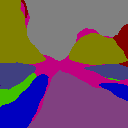

In [62]:
print(type(test(outputs[0])));
a = test(outputs[0]);               # returns reshaped array (128,128,3)
# a = a.reshape([128, 128, 3])    
print(a.shape)
from google.colab.patches import cv2_imshow
cv2_imshow(a)